In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
# Set sys path
sys.path.append(str(Path(os.getcwd()).parent))

In [12]:
# Adjust matplotlib settings for font inclusion
plt.rcParams['pdf.fonttype'] = 42  # Use Type 3 (PostScript) fonts
plt.rcParams['ps.fonttype'] = 42

# Set filpaths for data and figures
notebook_dir = os.getcwd()
file_path = Path(notebook_dir).parent / 'data' 

# Load data

In [13]:
d_cat = pd.read_excel(file_path / 'sample_info_2575processed_PRIDE.xlsx')
d_cat['Injection'] = d_cat['Injection'].astype(str)

In [14]:
d_prot = pd.read_csv(file_path / 'razor_intensities.tsv', sep='\t')
gene_dict = dict(zip(d_prot['Protein ID'], d_prot['Gene Names']))
d_prot = d_prot.set_index('Protein ID').iloc[:,16:]
d_prot.columns = [a.split(' ')[0] for a in d_prot.columns]
d_prot = np.log10(d_prot.replace(0, np.nan))
d_prot.columns = [str(a) for a in d_prot.columns]
d_prot = d_prot[[str(a) for a in d_cat['Injection']]]

# Slice and prepare all dataframes

Ctrl groups

In [15]:
ctrl_val = d_cat[d_cat['ConC'].isna() == True]
ctrl = d_cat[d_cat['ConC'].isna() == True]

ctrl = ctrl[ctrl['Group'].isin(['BIONIC_24hrs',
 'BIONIC_others', 'MONOGRAM', 'OBB_disc', 'TACE', 'XMINS_preop'])]
ctrl_val = ctrl_val[ctrl_val['Group'].isin(['BIONIC_preop',
 'MOTION', 'OBB_vali', 'XMINS_preop'])]

ctrl = ctrl.set_index('Injection')[['SRS', 'Sex', 'Age', 'ConC']]
ctrl_val = ctrl_val.set_index('Injection')[['SRS', 'Sex', 'Age', 'ConC']]

sepsis groups

In [16]:
sepsis_val = d_cat[d_cat['Group'] == 'GAinS_vali']
sepsis = d_cat[d_cat['Group'] == 'GAinS_disc']

sepsis = sepsis.dropna(subset='SRS')
sepsis_val = sepsis_val.dropna(subset='SRS')

sepsis['Injection'] = sepsis['Injection'].astype('str')
sepsis_val['Injection'] = sepsis_val['Injection'].astype('str')

sepsis = sepsis.set_index('Injection')[['SRS', 'Sex', 'Age', 'ConC']]
sepsis_val = sepsis_val.set_index('Injection')[['SRS', 'Sex', 'Age', 'ConC']]

protein data frames

In [17]:
ctrl_prot = d_prot.dropna(axis=0, thresh=0.05*2575)
ctrl_prot = ctrl_prot.T.loc[ctrl.index]

ctrl_prot_val = d_prot.dropna(axis=0, thresh=0.05*2575)
ctrl_prot_val = ctrl_prot_val.T.loc[ctrl_val.index]

In [18]:
sepsis_prot = d_prot.dropna(axis=0, thresh=0.05*2575)
sepsis_prot = sepsis_prot.T.loc[sepsis.index]

sepsis_prot_val = d_prot.dropna(axis=0, thresh=0.05*2575)
sepsis_prot_val = sepsis_prot_val.T.loc[sepsis_val.index]

# RF + XGBoost classifier

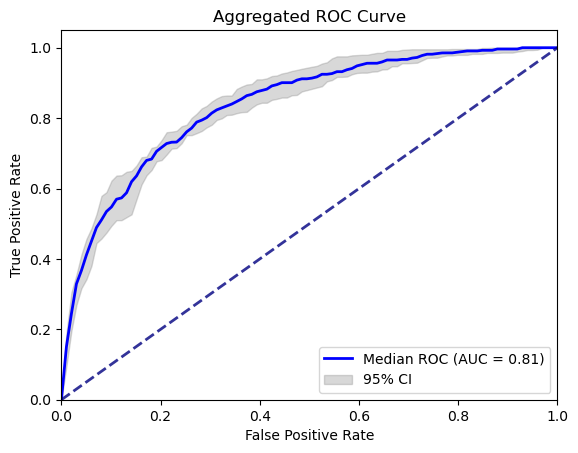

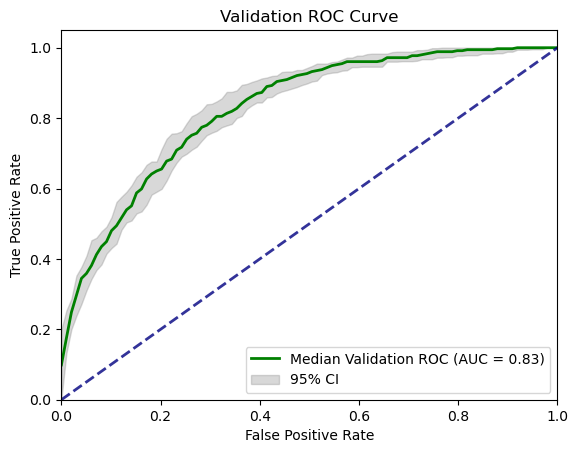

In [20]:
from utils.BaselineClassifier import BaselineClassifier
# Initialize the classifier
baseline = BaselineClassifier(sepsis_prot, sepsis[['SRS']], gene_dict, between='SRS')

# Perform classification 10 times and plot the aggregated ROC curve
baseline.classify_and_plot('non-SRS1', 'SRS1', n_runs=10, n_estimators=200)
baseline.validate_and_plot(sepsis_prot_val, sepsis_val[['SRS']], 'non-SRS1', 'SRS1')

In [ ]:
baseline.save_plots_to_pdf(file_path / 'Sepsis_RF_XGB.pdf')

Plots saved to d:\Notebooks\ADAPT-MS\data\Sepsis_RF_XGB.pdf.


# ADAPT-MS: t-test feature selection LR refitting per sample

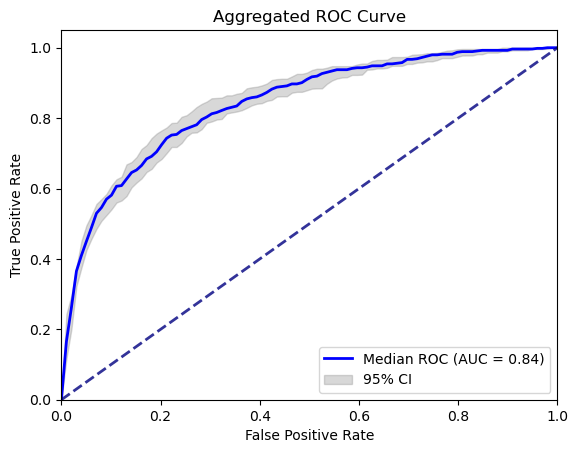

459it [00:28, 16.18it/s]


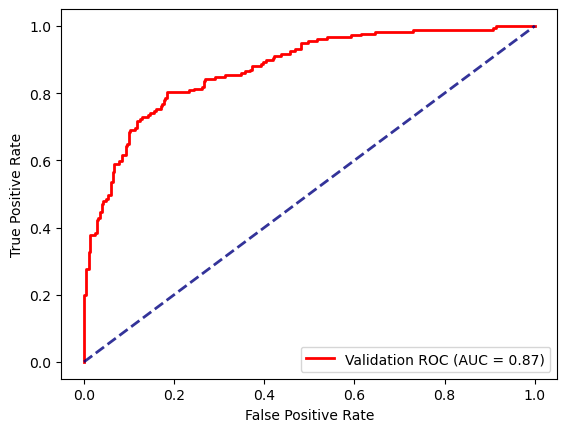

In [ ]:
from utils.AdaptmsClassifier import AdaptmsClassifierDF
#Initialize the classifier
adaptms = AdaptmsClassifierDF(sepsis_prot, sepsis, gene_dict, between='SRS')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms.classify_and_plot('non-SRS1', 'SRS1', n_runs=10, topn_features=50)

#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms.classify_dataframe(sepsis_prot_val, sepsis_val)
adaptms.plot_validation_roc('non-SRS1', 'SRS1')

In [ ]:
adaptms.save_plots_to_pdf(file_path / 'ADAPT-MS_Sepsis_SRS_applied.pdf')

Plots saved to d:\Notebooks\ADAPT-MS\data\ADAPT-MS_Sepsis_SRS_applied.pdf.


# ConC Multiclass with t-test feature selection between all groups

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


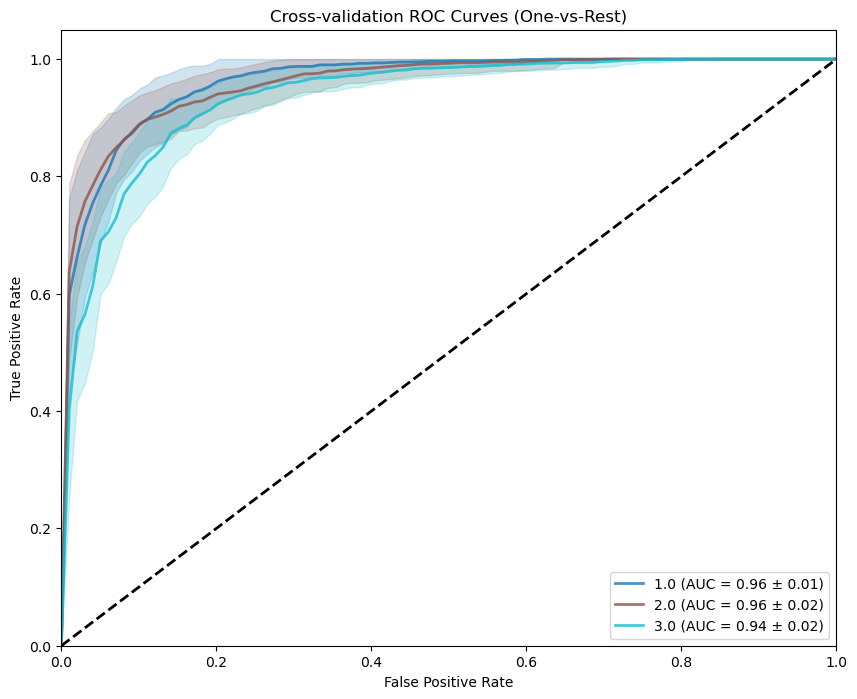

In [ ]:
from utils.AdaptmsMultiClassifier import AdaptmsMulticlassClassifier
#Initialize the classifier
adaptms_multi = AdaptmsMulticlassClassifier(sepsis_prot, sepsis, gene_dict, 'ConC')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms_multi.classify_and_plot(n_runs=10, n_features=50)

459it [02:21,  3.24it/s]


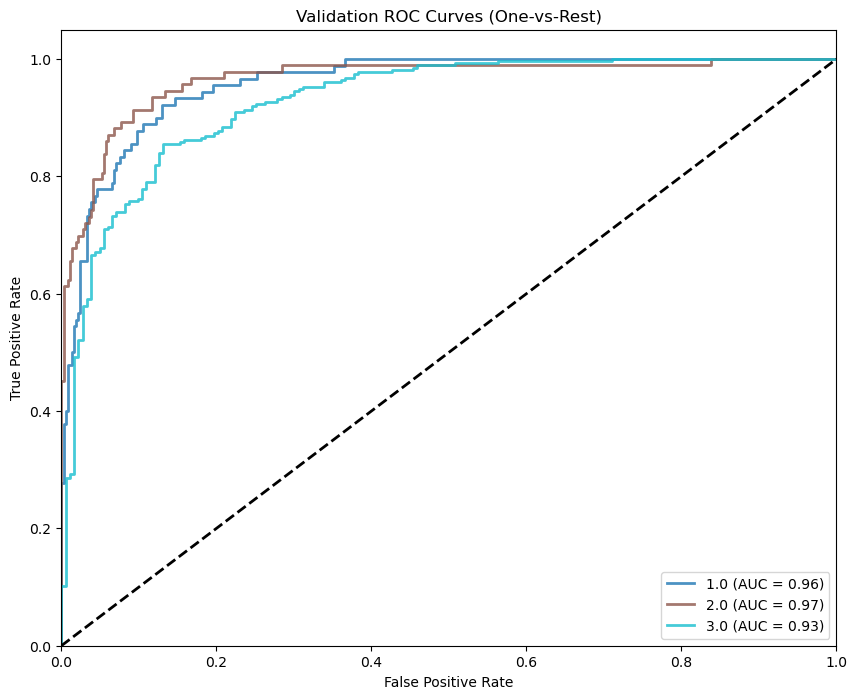

In [ ]:
#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms_multi.classify_dataframe(sepsis_prot_val, sepsis_val)
adaptms_multi.plot_validation_roc()

In [ ]:
adaptms_multi.save_figures(file_path / "ConC_classification.pdf")

Saved figure to d:\Notebooks\ADAPT-MS\data\ConC_classification.pdf\figure_1.pdf
Saved figure to d:\Notebooks\ADAPT-MS\data\ConC_classification.pdf\figure_2.pdf


# sepsis vs control

In [ ]:
sepsis['Sepsis'] = 'Sepsis'
sepsis_val['Sepsis'] = 'Sepsis'
ctrl['Sepsis'] = 'Control'
ctrl_val['Sepsis'] = 'Control'

In [ ]:
pool_sepsis = pd.concat([sepsis, ctrl])
pool_sepsis_val = pd.concat([sepsis_val, ctrl_val])
pool_sepsis_prot = pd.concat([sepsis_prot, ctrl_prot])
pool_sepsis_prot_val = pd.concat([sepsis_prot_val, ctrl_prot_val])

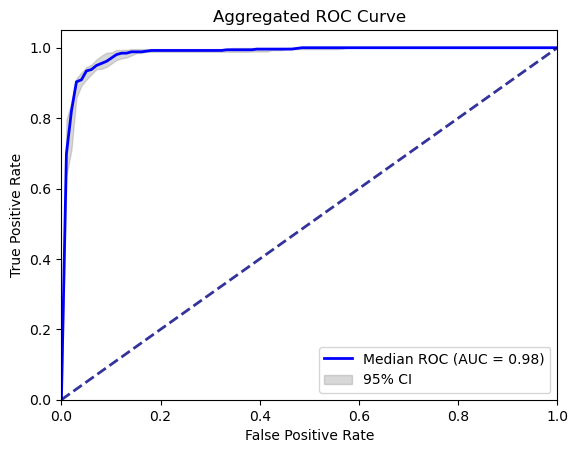

704it [01:31,  7.65it/s]


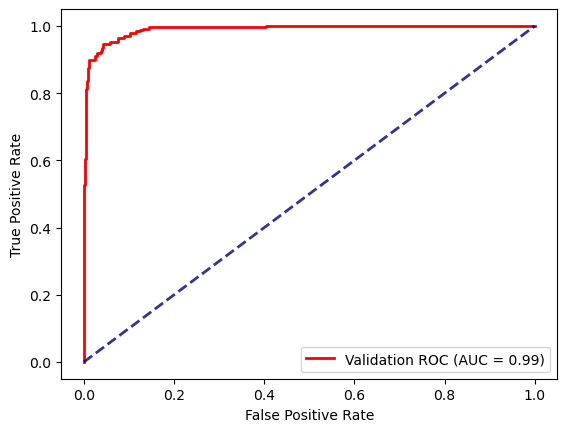

In [ ]:
#Initialize the classifier
adaptms = AdaptmsClassifier(pool_sepsis_prot, pool_sepsis, gene_dict, between='Sepsis')

#Perform classification 10 times and plot the aggregated ROC curve
adaptms.classify_and_plot('Sepsis', 'Control', n_runs=10, topn_features=50)

#Perform verification on 10 selected models and plot the aggregated ROC curve
adaptms.classify_dataframe(pool_sepsis_prot_val, pool_sepsis_val)
adaptms.plot_validation_roc('Sepsis', 'Control')

In [ ]:
adaptms.save_plots_to_pdf(file_path / 'sepsis_vs_ctrl_classification.pdf')

Plots saved to d:\Notebooks\ADAPT-MS\data\sepsis_vs_ctrl_classification.pdf.
